In [ ]:
pip install numpy pandas matplotlib scikit-learn tensorflow


データ読み込み完了: 15912 件
    Vd  Vg   L            Id
0  0.0   0  15  2.800000e-08
1  0.1   0  15  4.000000e-06
2  0.2   0  15  8.150000e-06
3  0.3   0  15  1.230000e-05
4  0.4   0  15  1.640000e-05


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5643 - mae: 0.4560 - val_loss: 0.4077 - val_mae: 0.3926
Epoch 2/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3902 - mae: 0.4054 - val_loss: 0.3234 - val_mae: 0.3748
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2780 - mae: 0.3694 - val_loss: 0.2630 - val_mae: 0.3499
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2470 - mae: 0.3536 - val_loss: 0.2292 - val_mae: 0.3359
Epoch 5/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2177 - mae: 0.3345 - val_loss: 0.2054 - val_mae: 0.3182
Epoch 6/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1931 - mae: 0.3150 - val_loss: 0.1887 - val_mae: 0.3107
Epoch 7/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1839 - mae: 0.3048 - val_loss: 0.1650 - val_mae: 0.2932
Epoch 8/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1828 - mae: 0.3033 - val_loss: 0.1505 - val_mae: 0.2729
Epoch 9/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

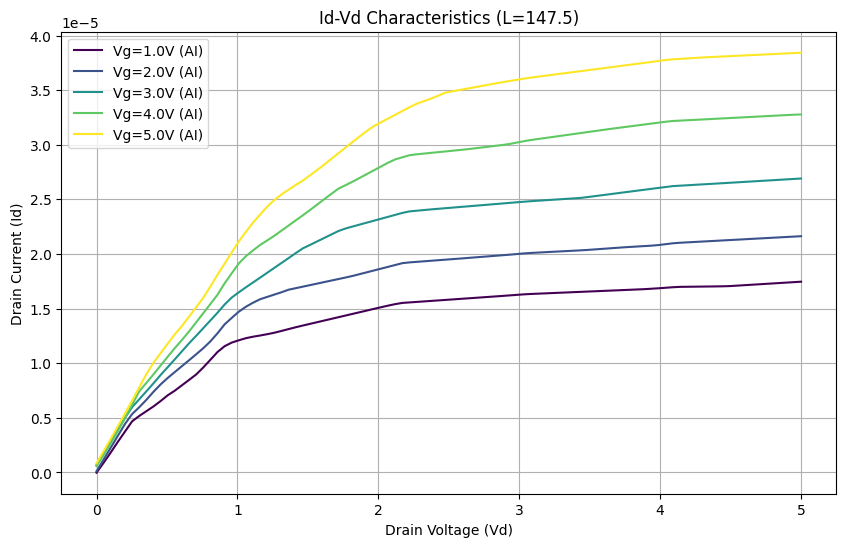

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. データの読み込み
# ==========================================
# 読み込むCSVファイル名を指定してください
csv_file_path = '/content/FET_data.csv'

# CSVの読み込み
# ※カラム名が異なる場合は適宜変更してください (例: 'GateLength'など)
try:
    df = pd.read_csv(csv_file_path)
    print(f"データ読み込み完了: {len(df)} 件")
    print(df.head()) # 先頭5行を表示して確認
except FileNotFoundError:
    print(f"エラー: ファイル '{csv_file_path}' が見つかりません。パスを確認してください。")
    exit()

# ==========================================
# 2. 前処理 (スケーリングと分割)
# ==========================================
# 入力: Vd, Vg, L (ゲート長)
# 出力: Id
input_columns = ['Vd', 'Vg', 'L']
output_columns = ['Id']

X = df[input_columns].values
y = df[output_columns].values

# データを訓練用とテスト用に分割 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化 (Standard Scaling)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 訓練データでスケーラーを学習(fit)し、変換
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# テストデータは訓練データの基準で変換のみ行う
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# ==========================================
# 3. AIモデルの構築
# ==========================================
model = tf.keras.Sequential([
    # 入力層: Vd, Vg, L の3つのパラメータを受け取るため input_shape=(3,)
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    # 出力層: Id
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 学習実行
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ==========================================
# 4. 予測結果の可視化
# ==========================================
# テストデータでの評価
loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"\nTest MSE Loss: {loss[0]:.4f}")

def plot_id_vd_at_specific_L(model, scaler_X, scaler_y, target_L, vg_list):
    """
    特定のゲート長(L)におけるId-Vd特性をプロットする関数
    """
    plt.figure(figsize=(10, 6))
    vd_range = np.linspace(df['Vd'].min(), df['Vd'].max(), 100)
    colors = plt.cm.viridis(np.linspace(0, 1, len(vg_list)))

    print(f"\n--- Plotting for Gate Length L = {target_L} ---")

    for i, vg in enumerate(vg_list):
        # 予測用入力データの作成: [Vd, Vg, L]
        # Vdは範囲で変化、VgとLは固定
        input_data = np.array([[vd, vg, target_L] for vd in vd_range])

        # スケーリングして予測
        input_scaled = scaler_X.transform(input_data)
        pred_scaled = model.predict(input_scaled, verbose=0)
        pred_id = scaler_y.inverse_transform(pred_scaled)

        # プロット
        plt.plot(vd_range, pred_id, label=f'Vg={vg}V (AI)', color=colors[i])

        # CSV内に近い条件のデータがあれば散布図で重ねる
        # (完全一致は難しいので、LとVgが近いデータを抽出)
        tolerance_L = 0.01  # 許容誤差など必要に応じて調整
        tolerance_Vg = 0.05

        mask = (
            (df['L'] >= target_L - tolerance_L) & (df['L'] <= target_L + tolerance_L) &
            (df['Vg'] >= vg - tolerance_Vg) & (df['Vg'] <= vg + tolerance_Vg)
        )
        true_data = df[mask]

        if not true_data.empty:
            plt.scatter(true_data['Vd'], true_data['Id'], color=colors[i], alpha=0.3, s=20, marker='x')

    plt.title(f'Id-Vd Characteristics (L={target_L})')
    plt.xlabel('Drain Voltage (Vd)')
    plt.ylabel('Drain Current (Id)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 設定例 ---
# CSVに含まれている代表的なゲート長(L)を指定してグラフを描画してください
# 例: L=0.5 の特性を見たい場合
target_L_value = df['L'].median()  # とりあえずデータの中央値を使用（手動で数値を指定可）
target_vg_list = [1.0, 2.0, 3.0, 4.0, 5.0] # 見たいVgのリスト

# グラフ描画実行
plot_id_vd_at_specific_L(model, scaler_X, scaler_y, target_L_value, target_vg_list)

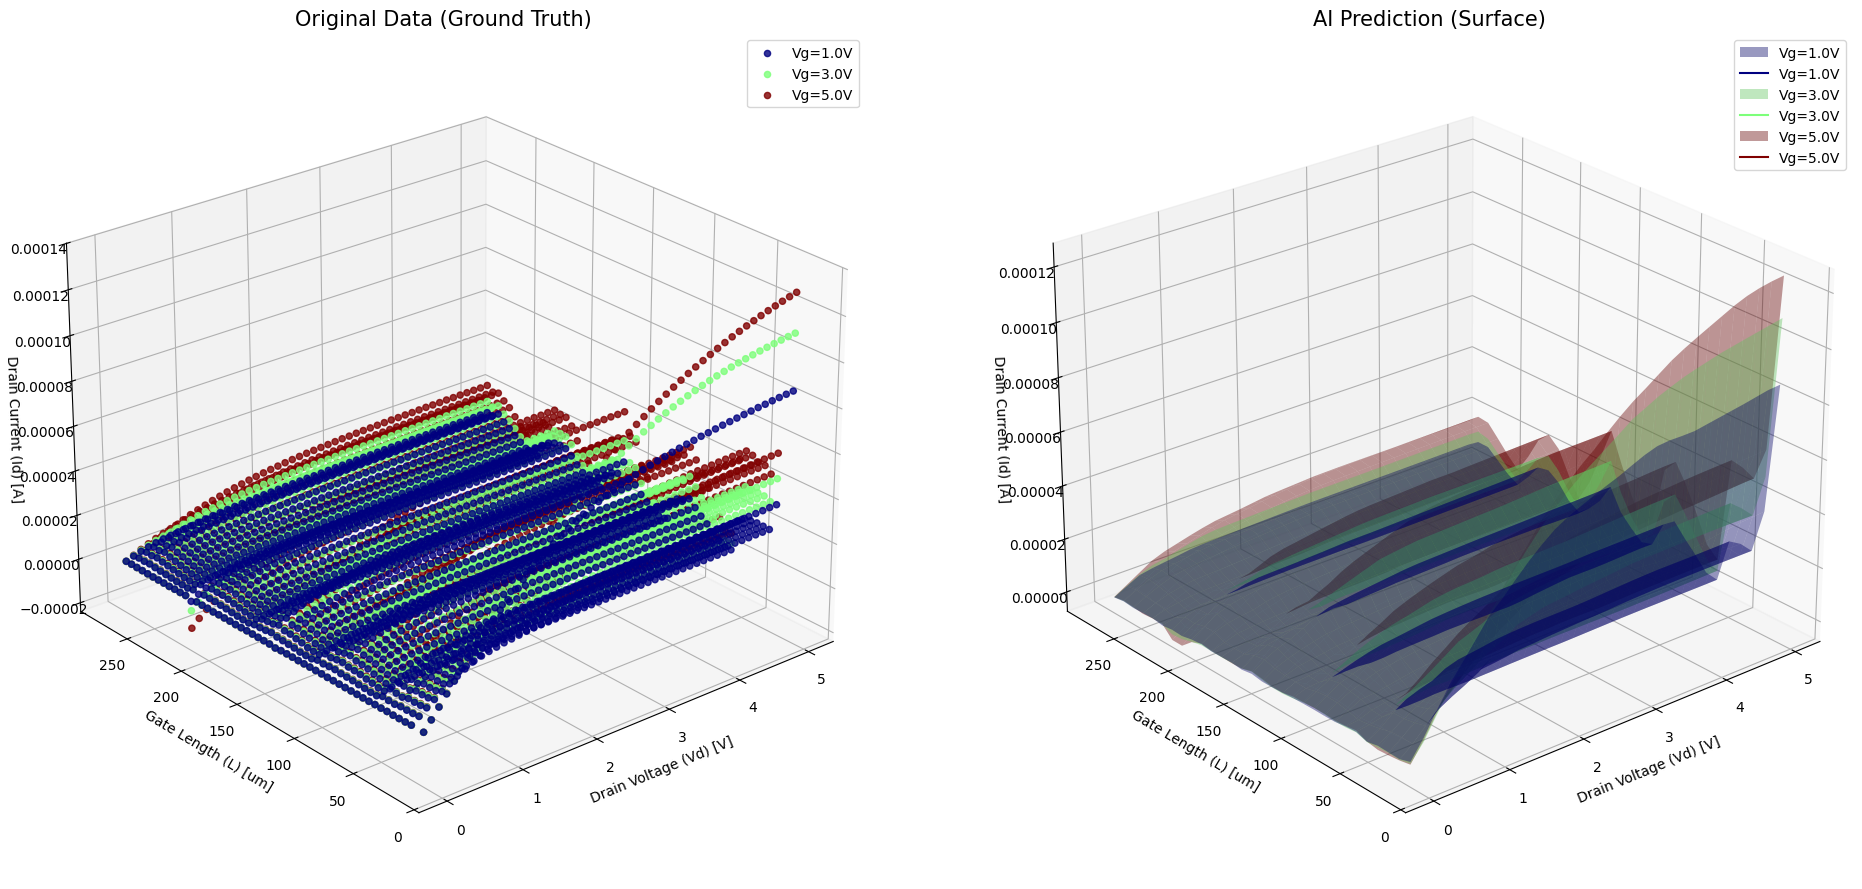

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_comparison(df, model, scaler_X, scaler_y, target_vgs):
    """
    3Dグラフで元のデータとAI予測を比較表示する関数
    軸: x=Vd, y=L, z=Id
    """
    fig = plt.figure(figsize=(20, 9))

    # -----------------------------
    # 1. 元データ (Original Data)
    # -----------------------------
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Original Data (Ground Truth)", fontsize=15)
    ax1.set_xlabel('Drain Voltage (Vd) [V]')
    ax1.set_ylabel('Gate Length (L) [um]')
    ax1.set_zlabel('Drain Current (Id) [A]')

    # -----------------------------
    # 2. AI予測 (AI Prediction)
    # -----------------------------
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("AI Prediction (Surface)", fontsize=15)
    ax2.set_xlabel('Drain Voltage (Vd) [V]')
    ax2.set_ylabel('Gate Length (L) [um]')
    ax2.set_zlabel('Drain Current (Id) [A]')

    # カラーマップの準備
    colors = plt.cm.jet(np.linspace(0, 1, len(target_vgs)))

    # メッシュグリッドの作成（AI予測の曲面描画用）
    # VdとLの範囲をデータから取得してグリッド化
    vd_range = np.linspace(df['Vd'].min(), df['Vd'].max(), 30)
    l_range = np.linspace(df['L'].min(), df['L'].max(), 30)
    vd_mesh, l_mesh = np.meshgrid(vd_range, l_range)

    # 各Vgごとにプロット
    for i, vg in enumerate(target_vgs):
        color = colors[i]

        # --- A. 元データのプロット (散布図) ---
        # 指定したVgに近いデータを抽出 (許容誤差 tolerance を設定)
        tolerance = 0.1
        subset = df[(df['Vg'] >= vg - tolerance) & (df['Vg'] <= vg + tolerance)]

        if not subset.empty:
            ax1.scatter(
                subset['Vd'],
                subset['L'],
                subset['Id'],
                c=[color],
                label=f'Vg={vg}V',
                s=20,
                alpha=0.8
            )

        # --- B. AI予測のプロット (曲面) ---
        # メッシュグリッドを展開して入力データを作成 [Vd, Vg, L]
        # Vgは固定値で埋める
        grid_points = np.c_[vd_mesh.ravel(), np.full(vd_mesh.size, vg), l_mesh.ravel()]

        # スケーリング -> 予測 -> 逆スケーリング
        input_scaled = scaler_X.transform(grid_points)
        pred_scaled = model.predict(input_scaled, verbose=0)
        pred_id = scaler_y.inverse_transform(pred_scaled)

        # 形状をメッシュに戻す
        pred_id_mesh = pred_id.reshape(vd_mesh.shape)

        # ワイヤーフレームまたはサーフェスで描画
        # (面が重なって見づらい場合は alpha を下げるか wireframe に変更してください)
        ax2.plot_surface(
            vd_mesh,
            l_mesh,
            pred_id_mesh,
            color=color,
            alpha=0.4,
            label=f'Vg={vg}V'
        )

        # 凡例用のダミープロット (Surfaceは凡例が出にくいため)
        ax2.plot([], [], [], color=color, label=f'Vg={vg}V')

    # 視点の調整 (必要に応じて変更してください)
    ax1.view_init(elev=25, azim=-130)
    ax2.view_init(elev=25, azim=-130)

    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()

# --- 実行 ---
# 表示したい Vg のリスト (データに含まれる代表的な値を選んでください)
target_vgs_list = [1.0, 3.0, 5.0]

# グラフ描画関数の呼び出し
plot_3d_comparison(df, model, scaler_X, scaler_y, target_vgs_list)


--- Predicting for Negative Vg at L = 275 ---


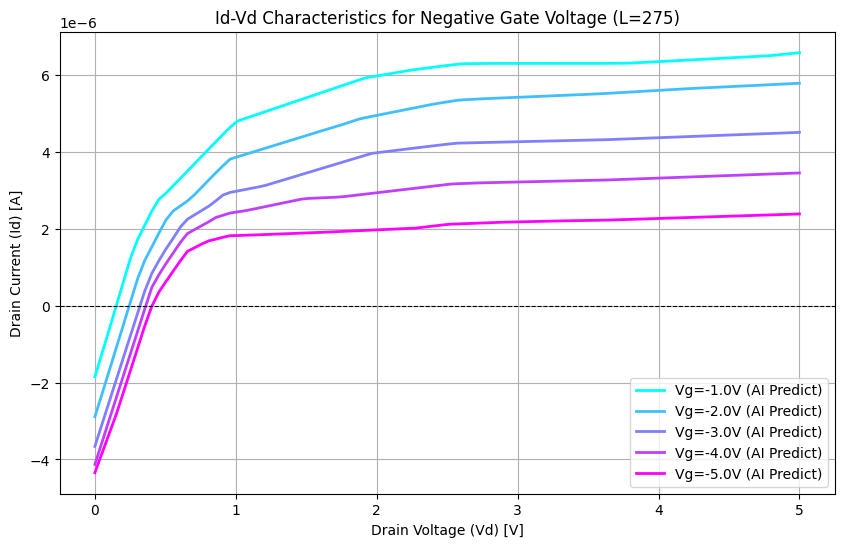

In [ ]:
def plot_negative_vg_curves(model, scaler_X, scaler_y, target_L, negative_vg_list):
    """
    マイナスのVgにおけるId-Vd特性を予測してプロットする関数
    """
    plt.figure(figsize=(10, 6))

    # Vdの範囲 (0V ～ 5V 程度)
    vd_range = np.linspace(0, 5, 100)

    # 寒色系のカラーマップを使用 (マイナス温度や電圧のイメージ)
    colors = plt.cm.cool(np.linspace(0, 1, len(negative_vg_list)))

    print(f"\n--- Predicting for Negative Vg at L = {target_L} ---")

    for i, vg in enumerate(negative_vg_list):
        # 入力データ作成: [Vd, Vg, L]
        input_data = np.array([[vd, vg, target_L] for vd in vd_range])

        # スケーリング -> 予測 -> 逆スケーリング
        input_scaled = scaler_X.transform(input_data)
        pred_scaled = model.predict(input_scaled, verbose=0)
        pred_id = scaler_y.inverse_transform(pred_scaled)

        # プロット
        plt.plot(vd_range, pred_id, label=f'Vg={vg}V (AI Predict)', color=colors[i], linewidth=2)

    plt.title(f'Id-Vd Characteristics for Negative Gate Voltage (L={target_L})')
    plt.xlabel('Drain Voltage (Vd) [V]')
    plt.ylabel('Drain Current (Id) [A]')

    # 電流0のラインを強調表示
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

    plt.legend()
    plt.grid(True)
    plt.show()

# --- 設定と実行 ---

# 1. ゲート長 (L) を固定
# データの中央値、または任意の値を指定してください
target_L_value = 275

# 2. 予測させたいマイナスのVgリスト
# デプレッション型やPMOSでない限り、通常はId=0になるはずです
target_negative_vgs = [-1.0, -2.0, -3.0, -4.0, -5.0]

# 3. グラフ描画
plot_negative_vg_curves(model, scaler_X, scaler_y, target_L_value, target_negative_vgs)

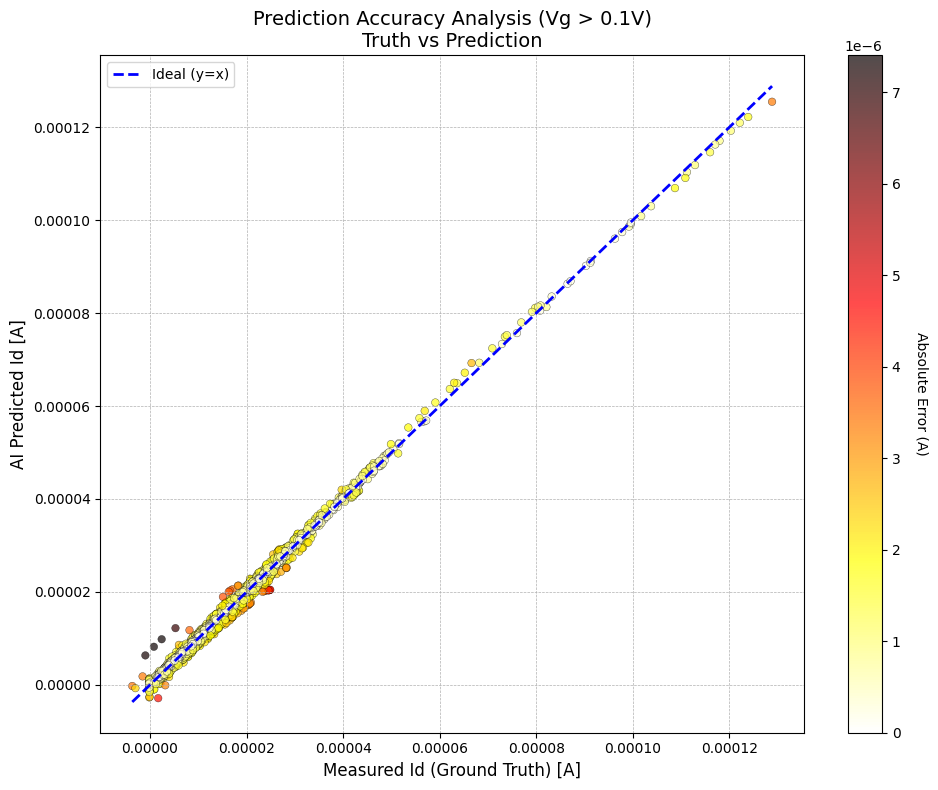


=== 誤差統計量 (Vg > 0.1V) ===
平均絶対誤差 (MAE) : 0.000001 A
二乗平均平方根誤差 (RMSE): 0.000001 A
最大誤差 (Max Error): 0.000007 A


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_prediction_error_analysis(model, scaler_X, scaler_y, X_test, y_test):
    """
    テストデータを用いた予測精度と誤差の分析プロット
    """
    # 1. テストデータに対する予測を実行
    # (X_testはスケーリング前の状態を想定しているため、ここでスケーリング)
    X_test_scaled_for_pred = scaler_X.transform(X_test)
    pred_scaled = model.predict(X_test_scaled_for_pred, verbose=0)

    # スケールを元の単位に戻す
    y_true = y_test.flatten() # 1次元配列化
    y_pred = scaler_y.inverse_transform(pred_scaled).flatten()

    # 2. 分析用データフレームの作成
    df_analysis = pd.DataFrame({
        'Vg': X_test[:, 1], # 2列目がVg
        'Id_True': y_true,
        'Id_Pred': y_pred
    })

    # Vgがプラスのデータのみ抽出 (閾値付近のノイズを除去するため少し余裕を持たせて > 0.1V としています)
    df_positive_vg = df_analysis[df_analysis['Vg'] > 0.1].copy()

    # 3. 誤差の計算
    # 残差 (Residual) = 実測値 - 予測値
    df_positive_vg['Residual'] = df_positive_vg['Id_True'] - df_positive_vg['Id_Pred']
    # 絶対誤差 (Absolute Error)
    df_positive_vg['Abs_Error'] = df_positive_vg['Residual'].abs()

    # -------------------------------------------
    # グラフ描画: 実測値 vs 予測値 プロット
    # -------------------------------------------
    plt.figure(figsize=(10, 8))

    # 誤差の大きさに応じて色付けするための正規化
    norm = mcolors.Normalize(vmin=0, vmax=df_positive_vg['Abs_Error'].max())
    cmap = cm.hot_r # 誤差が大きいほど赤く表示 (hot_rはhotの反転)

    # 散布図の描画
    scatter = plt.scatter(
        df_positive_vg['Id_True'],
        df_positive_vg['Id_Pred'],
        c=df_positive_vg['Abs_Error'], # 色で誤差の大きさを表現
        cmap=cmap,
        norm=norm,
        alpha=0.7,
        s=30,
        edgecolors='k',
        linewidth=0.3
    )

    # 理想線 (Perfect Prediction, y=x) を引く
    min_val = min(df_positive_vg['Id_True'].min(), df_positive_vg['Id_Pred'].min())
    max_val = max(df_positive_vg['Id_True'].max(), df_positive_vg['Id_Pred'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'b--', label='Ideal (y=x)', linewidth=2)

    # カラーバーの追加
    cbar = plt.colorbar(scatter)
    cbar.set_label('Absolute Error (A)', rotation=270, labelpad=20)

    plt.title('Prediction Accuracy Analysis (Vg > 0.1V)\nTruth vs Prediction', fontsize=14)
    plt.xlabel('Measured Id (Ground Truth) [A]', fontsize=12)
    plt.ylabel('AI Predicted Id [A]', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

    # --- 統計量の表示 ---
    print("\n=== 誤差統計量 (Vg > 0.1V) ===")
    mae = df_positive_vg['Abs_Error'].mean()
    rmse = np.sqrt((df_positive_vg['Residual']**2).mean())
    max_error = df_positive_vg['Abs_Error'].max()
    print(f"平均絶対誤差 (MAE) : {mae:.6f} A")
    print(f"二乗平均平方根誤差 (RMSE): {rmse:.6f} A")
    print(f"最大誤差 (Max Error): {max_error:.6f} A")

# 実行
# ※ X_test, y_test は最初のコードで分割した変数を使用します
plot_prediction_error_analysis(model, scaler_X, scaler_y, X_test, y_test)

L=275 で見つかった Vgリスト: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


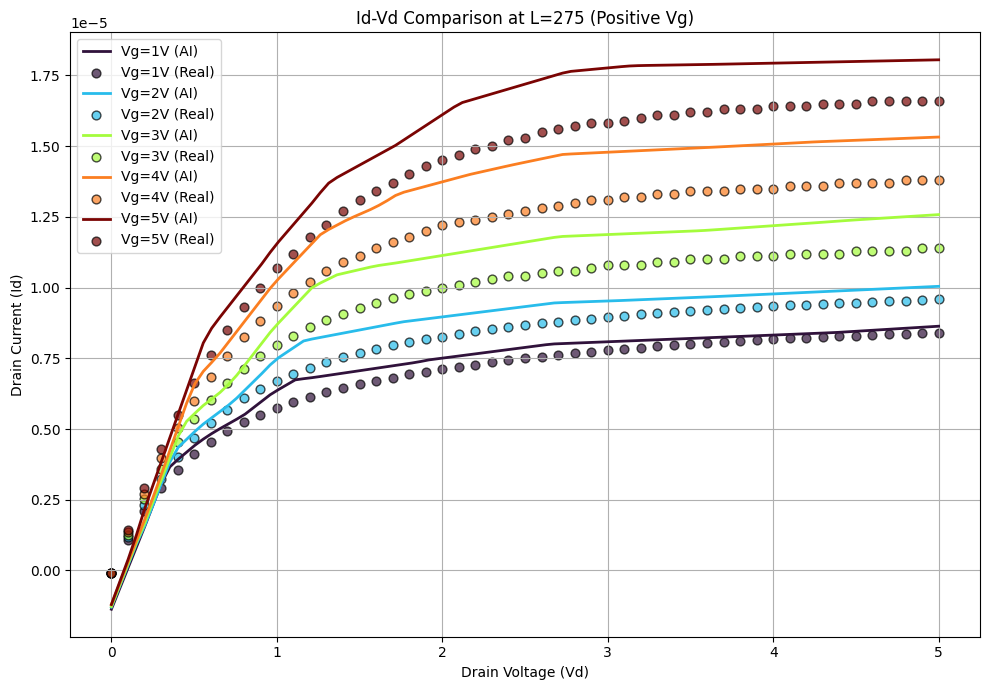

In [ ]:
def plot_comparison_at_L275(df, model, scaler_X, scaler_y):
    """
    L=275 における、Vgプラス領域の AI予測 vs 実測データ 比較
    """
    target_L = 275

    # -------------------------------------------------------
    # 1. 比較対象となる Vg のリストをデータから抽出
    # -------------------------------------------------------
    # L=275 (誤差許容) かつ Vg > 0 のデータを抽出
    tolerance_L = 0.5 # データのLが浮動小数点の場合の許容誤差

    subset = df[
        (df['L'] >= target_L - tolerance_L) &
        (df['L'] <= target_L + tolerance_L) &
        (df['Vg'] > 0)
    ]

    # データに含まれている Vg の種類を取得してソート
    available_vgs = sorted(subset['Vg'].unique())

    if len(available_vgs) == 0:
        print(f"警告: L={target_L} 付近のデータが見つかりません。")
        print("CSVのLの値を確認するか、target_Lの値を変更してください。")
        return

    print(f"L={target_L} で見つかった Vgリスト: {available_vgs}")

    # -------------------------------------------------------
    # 2. グラフ描画
    # -------------------------------------------------------
    plt.figure(figsize=(10, 7))

    # Vdの範囲 (データの最大値まで)
    vd_max = df['Vd'].max()
    vd_range = np.linspace(0, vd_max, 100)

    # カラーマップ
    colors = plt.cm.turbo(np.linspace(0, 1, len(available_vgs)))

    for i, vg in enumerate(available_vgs):
        color = colors[i]

        # --- A. AIによる予測 (実線) ---
        # 入力: [Vd, Vg, L]
        input_data = np.array([[vd, vg, target_L] for vd in vd_range])

        input_scaled = scaler_X.transform(input_data)
        pred_scaled = model.predict(input_scaled, verbose=0)
        pred_id = scaler_y.inverse_transform(pred_scaled)

        plt.plot(vd_range, pred_id, color=color, linestyle='-', linewidth=2, label=f'Vg={vg}V (AI)')

        # --- B. 実際のデータ (散布図/丸プロット) ---
        # そのVgに対応する実データを抽出
        # Vgも浮動小数点の誤差を考慮して幅を持たせて抽出
        tolerance_Vg = 0.05
        real_data = subset[
            (subset['Vg'] >= vg - tolerance_Vg) &
            (subset['Vg'] <= vg + tolerance_Vg)
        ]

        if not real_data.empty:
            plt.scatter(real_data['Vd'], real_data['Id'], color=color, marker='o', s=40, edgecolors='black', alpha=0.7, label=f'Vg={vg}V (Real)')

    plt.title(f'Id-Vd Comparison at L={target_L} (Positive Vg)')
    plt.xlabel('Drain Voltage (Vd)')
    plt.ylabel('Drain Current (Id)')

    # 凡例が多くなりすぎないように調整（必要に応じてコメントアウト解除）
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 実行 ---
plot_comparison_at_L275(df, model, scaler_X, scaler_y)